# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-learn==1.1.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score
)
from IPython.display import display
import warnings
from scipy import stats

     |████████████████████████████████| 30.8 MB 46 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


### Загрузка и базовая проверка данных

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv') # данные по первому региону
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_2 = pd.read_csv('/datasets/geo_data_1.csv') # данные по второму региону
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_3 = pd.read_csv('/datasets/geo_data_2.csv') # данные по третьему региону
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**ВЫВОД** 

Все три датасета одинакового размера; пропусков и аномалий не обнаружено; типы данных в норме.

### Анализ целевого признака

Проанализируем наш целнвой признак *- объем запаса нефти -* для каждого региона.

In [8]:
#новая таюлица: значения целевого признака по регионам
product = pd.concat([data_1['product'], data_2['product'], data_3['product']], axis= 1)
product.columns = ['region_1', 'region_2', 'region_3']
product.head()

,region_1,region_2,region_3
0,105.280062,3.179103,27.758673
1,73.037750,26.953261,56.069697
2,85.265647,134.766305,62.871910
3,168.620776,137.945408,114.572842
4,154.036647,134.766305,149.600746


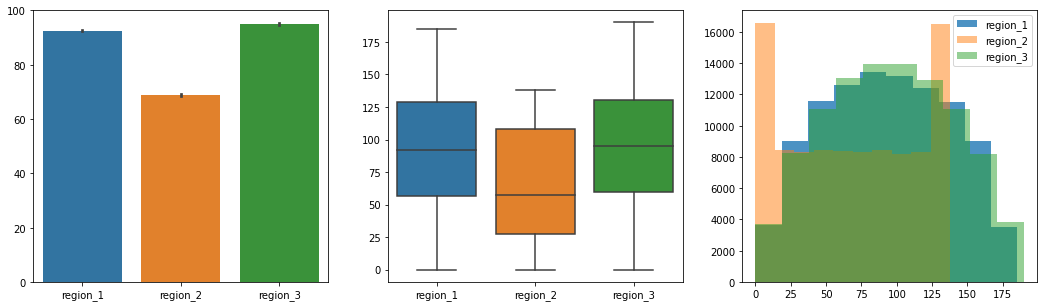

In [9]:
fig, axis = plt.subplots(1,3 , figsize=(18,5))

sns.barplot(data=product, ax=axis[0]);
sns.boxplot(data=product, ax=axis[1])

plt.hist(product['region_1'], alpha = 0.8, label='region_1')
plt.hist(product['region_2'], alpha = 0.5, label='region_2')
plt.hist(product['region_3'], alpha = 0.5, label='region_3')
plt.legend(loc='upper right')
plt.show()

***Вывод:*** первый и третий регионы имеют схожую картину по общему запасу сырья, медианному значению и распределению. Для второго региона имеем сниженные показатели и странное распределение.

Рассмотрим второй регион более подробно.

In [10]:
data_2['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [11]:
len(data_2.query('product == 0'))

8235

In [12]:
len(data_2.query('26.95 < product < 107.81'))

50387

***Вывод:*** половина скважин второго региона имеет либо очень маленький, либо очень большой запас сырья; вторая половина скважин имеет примерно один уровень запас сырья.

Проверим данные на корреляцию признаков и целевого признака.

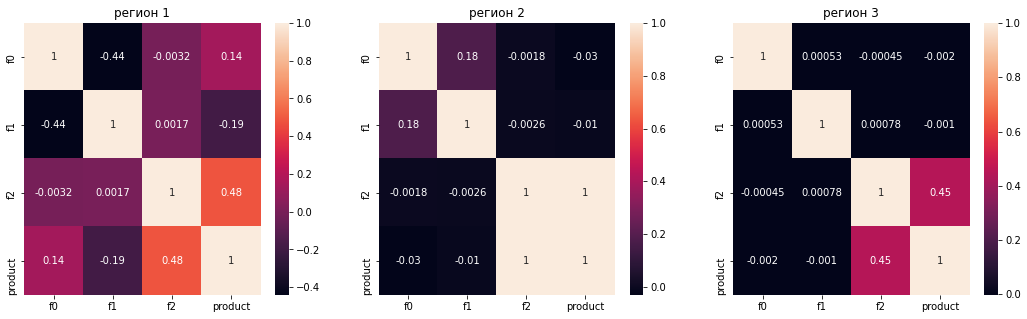

In [13]:
fig, axis = plt.subplots(1,3 , figsize=(18,5))

sns.heatmap(data_1.corr(), annot=True, ax=axis[0]).set_title("регион 1")
sns.heatmap(data_2.corr(), annot=True, ax=axis[1]).set_title("регион 2")
sns.heatmap(data_3.corr(), annot=True, ax=axis[2]).set_title("регион 3");

***Вывод:*** для второго региона иммет абсолютную корреляцию между целевым признаком - product -  и признаком - f2; для других регионов значимых корреляций не выявлено.

### Формирование выборок

Удалим столбец "id" из всех датасетов чтобы не перегружать модель.
Сформируем тренировочную и валидационную выборки для каждого набора данных в соотношении 75:25.

In [14]:
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)
data_3 = data_3.drop('id', axis=1)

In [16]:
#фцнкция для формирование выборок
def get_train_valid(data):
    data_train, data_valid = train_test_split(data, test_size=0.25, random_state=12345)  
    return data_train, data_valid

#функции для формирования признаков и целевого признака
def get_features(data, column_name):
    return data.drop([column_name], axis = 1)
def get_target(data, column_name):
    return data[column_name]

def get_features_target(data, column_name):
    features = get_features(data, column_name)
    target = get_target(data, column_name)
    return features, target

In [17]:
#выборки для первого региона
data_1_train, data_1_valid = get_train_valid(data_1)
features_1_train, target_1_train = get_features_target(data_1_train, 'product')
features_1_valid, target_1_valid = get_features_target(data_1_valid, 'product')
print('Размер выборок для первого региона:')
print(features_1_train.shape, target_1_train.shape, features_1_valid.shape, target_1_valid.shape)
print('')
#выборки для второго региона
data_2_train, data_2_valid = get_train_valid(data_2)
features_2_train, target_2_train = get_features_target(data_2_train, 'product')
features_2_valid, target_2_valid = get_features_target(data_2_valid, 'product')
print('Размер выборок для первого региона:')
print(features_2_train.shape, target_2_train.shape, features_2_valid.shape, target_2_valid.shape)
print('')
#выборки для третьего региона
data_3_train, data_3_valid = get_train_valid(data_3)
features_3_train, target_3_train = get_features_target(data_3_train, 'product')
features_3_valid, target_3_valid = get_features_target(data_3_valid, 'product')
print('Размер выборок для первого региона:')
print(features_3_train.shape, target_3_train.shape, features_3_valid.shape, target_3_valid.shape)
print('')

Размер выборок для первого региона:
(75000, 3) (75000,) (25000, 3) (25000,)

Размер выборок для первого региона:
(75000, 3) (75000,) (25000, 3) (25000,)

Размер выборок для первого региона:
(75000, 3) (75000,) (25000, 3) (25000,)



### Стандартизация данных

Приведем все численные признаки к одному масштабу.

In [18]:
def scaler(train_set, valid_set):
    numeric = train_set.columns
    scaler = StandardScaler()
    scaler.fit(train_set[numeric])
    train_set[numeric] = scaler.transform(train_set[numeric])
    valid_set[numeric] = scaler.transform(valid_set[numeric])
    return train_set, valid_set

In [19]:
features_1_train, features_1_valid = scaler(features_1_train, features_1_valid)
features_2_train, features_2_valid = scaler(features_2_train, features_2_valid)
features_3_train, features_3_valid = scaler(features_3_train, features_3_valid)

print('Масштабированные признаки для первого региона')
print(features_1_train.head())
print('Масштабированные признаки для второго региона')
print(features_2_train.head())
print('Масштабированные признаки для третьего региона')
print(features_3_train.head())

Масштабированные признаки для первого региона
             f0        f1        f2
27212 -0.544828  1.390264 -0.094959
7866   1.455912 -0.480422  1.209567
62041  0.260460  0.825069 -0.204865
70185 -1.837105  0.010321 -0.147634
82230 -1.299243  0.987558  1.273181
Масштабированные признаки для второго региона
             f0        f1        f2
27212 -0.850855  0.624428  0.296943
7866   1.971935  1.832275  0.294333
62041  1.079305  0.170127 -0.296418
70185 -1.512028 -0.887837 -0.880471
82230 -1.804775 -0.718311 -0.293255
Масштабированные признаки для третьего региона
             f0        f1        f2
27212 -0.526160  0.776329 -0.400793
7866  -0.889625 -0.404070 -1.222936
62041 -1.133984  0.208576  0.296765
70185  1.227045  1.570166 -0.764556
82230 -0.194289  0.878312  0.840821


**ВЫВОД**
- данные были успешно загружены
- все три датасета одинакого размера
- пропусков и аномалий не обнаружено
- типы данных в норме
- первый и третий регионы имеют схожую картину по общему запасу сырья, медианному значению и распределению
- для второго региона имеем сниженные показатели и ненормальое распределение
- для второго региона иммем абсолютную корреляцию между целевым признаком и признаком - f2
- для других регионов значимых корреляций не выявлено
- для всех датасетов удалили столбец 'id' чтобы не перегружать модель
- сформировали тренировочную и валидационную выборки для каждого набора данных в соотношении 75:25
- промасштабировали признаки для каждого набора данных

## Обучение и проверка модели

Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке.

In [22]:
def fit_model(features, target):
    model = LinearRegression()
    model.fit(features, target)
    return model

# def predict_model(model, features_valid, index_values):
#     predictions = model.predict(features_valid)
#     np_array = np.array(predictions)
#     predictions = pd.Series(np_array, index = index_values)
#     return predictions

def predict_model(model, features_valid):
    predictions = model.predict(features_valid)
    return predictions

def get_metrics(target, predicted):
    print("MSE =", mean_squared_error(target, predicted))
    print("RMSE =", mean_squared_error(target, predicted) ** 0.5)
    print("R2 =", r2_score(target, predicted))

def get_mean(title, value):
    print(title, value.mean())

In [23]:
model_1 = fit_model(features_1_train, target_1_train)
predictions_1 = predict_model(model_1, features_1_valid)
get_metrics(target_1_valid, predictions_1)
get_mean('Средний реальный запас сырья', target_1_valid)
get_mean('Средний предсказанный запас сырья', predictions_1)

MSE = 1412.2129364399243
RMSE = 37.5794217150813
R2 = 0.27994321524487786
Средний реальный запас сырья 92.07859674082927
Средний предсказанный запас сырья 92.59256778438035


In [24]:
model_2 = fit_model(features_2_train, target_2_train)
predictions_2 = predict_model(model_2, features_2_valid)
get_metrics(target_2_valid, predictions_2)
get_mean('Средний реальный запас сырья', target_2_valid)
get_mean('Средний предсказанный запас сырья', predictions_2)

MSE = 0.7976263360391157
RMSE = 0.893099286775617
R2 = 0.9996233978805127
Средний реальный запас сырья 68.72313602435997
Средний предсказанный запас сырья 68.728546895446


In [25]:
model_3 = fit_model(features_3_train, target_3_train)
predictions_3 = predict_model(model_3, features_3_valid)
get_metrics(target_3_valid, predictions_3)
get_mean('Средний реальный запас сырья', target_3_valid)
get_mean('Средний предсказанный запас сырья', predictions_3)

MSE = 1602.3775813236196
RMSE = 40.02970873393434
R2 = 0.20524758386040443
Средний реальный запас сырья 94.88423280885438
Средний предсказанный запас сырья 94.96504596800489


**ВЫВОД**  

Самый высокий коэффициент детерминации у второго региона (а значит и модель самая качественная), второе место занимает модель первого  региона, третье - третьего региона.

## Подготовка к расчёту прибыли

Вычислим необходимый объём сырья для безубыточной разработки новой скважины на основе следующих данных:

In [29]:
budget = 10000000000 #бюджет на разработку скважин в регионе
price = 450000 #доход с каждой единицы продукта
points_per_budget = 200 #количество лучших точек для разработки

In [30]:
volume = budget / price / points_per_budget #объём сырья для безубыточной разработки новой скважины

In [31]:
mean_volume_1 = data_1['product'].mean() #cредний объем запасов скважины в 1 регионе
mean_volume_2 = data_2['product'].mean() #cредний объем запасов скважины в 2 регионе
mean_volume_3 = data_3['product'].mean() #cредний объем запасов скважины в 3 регионе

In [32]:
print('Объем сырья для новой разработки скважины:', round(volume,2))
print('Cредний объем запасов скважины в 1 регионе:', mean_volume_1.round(2))
print('Cредний объем запасов скважины в 2 регионе:', mean_volume_2.round(2))
print('Cредний объем запасов скважины в 3 регионе:', mean_volume_3.round(2))

Объем сырья для новой разработки скважины: 111.11
Cредний объем запасов скважины в 1 регионе: 92.5
Cредний объем запасов скважины в 2 регионе: 68.83
Cредний объем запасов скважины в 3 регионе: 95.0


**ВЫВОД**  

Средний объем запасов скважины во всех регионах ниже необходимого для безубыточной разработки новой скважины; средний объем во втором регионе ниже, чем в первом и третьем.

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
- примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
- найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [33]:
def profit(target, predictions):
    preds_sorted = pd.Series(predictions).sort_values(ascending=False)[:points_per_budget]
    selected = target.reset_index(drop = True)[preds_sorted.index]

    # КОД РЕВЬЮЕРА, debug
    if sorted(preds_sorted[:points_per_budget].index) != sorted(selected.index):
        print("index error!")
    if target.reset_index(drop = True)[preds_sorted.index].shape[0] > preds_sorted.shape[0]:
        print("shape mismatch! actual targets shape:", target[preds_sorted.index].shape[0])

    return price * selected.sum() - budget

In [34]:
# КОД РЕВЬЮЕРА
_preds = pd.Series([1, 2, 2, 5, 5], index=[0, 1, 1, 3, 3])
_target = pd.Series([1, 2, 2, 5, 5], index=[0, 1, 1, 3, 3]).reset_index(drop=True)

_target.loc[_preds.index]

0    1
1    2
1    2
3    5
3    5
dtype: int64

Вычислим прибыль по топ-200 предсказаниям для каждого региона.

In [35]:
profit_1 = profit(target_1_valid, predictions_1).round(2)
profit_2 = profit(target_2_valid, predictions_2).round(2)
profit_3 = profit(target_3_valid, predictions_3).round(2)
print(profit_1)
print(profit_2)
print(profit_3)

3320826043.14
2415086696.68
2710349963.6


***Вывод:*** второй регион имеет минимальное значение прибыли; на втором месте третий регион, на первом первый регион.

In [36]:
state = np.random.RandomState(12345)
def bootstrap(target, predictions):
    
    values = []
    for i in range(1000):
        value = pd.Series(predictions).sample(n=500, replace=True, random_state=state)
        values.append(profit(target,value))
        
    return pd.Series(values)

In [37]:
bootstrap_1 = bootstrap(target_1_valid, predictions_1)
bootstrap_2 = bootstrap(target_2_valid, predictions_2)
bootstrap_3 = bootstrap(target_3_valid, predictions_3)

In [38]:
def metrics(bootstrap):
    print("Средняя выручка:", bootstrap.mean().round(1))
    print("95%-й доверительный интервал: (", bootstrap.quantile(0.025).round(2), ',', bootstrap.quantile(0.975).round(2), ')')
    print("Риск:", st.percentileofscore(bootstrap, 0).round(2), '%')

In [39]:
metrics(bootstrap_1)

Средняя выручка: 396164984.8
95%-й доверительный интервал: ( -111215545.89 , 909766941.55 )
Риск: 6.9 %


In [40]:
metrics(bootstrap_2)

Средняя выручка: 461155817.3
95%-й доверительный интервал: ( 78050810.75 , 862952060.26 )
Риск: 0.7 %


In [41]:
metrics(bootstrap_3)

Средняя выручка: 392950475.2
95%-й доверительный интервал: ( -112227625.38 , 934562914.55 )
Риск: 6.5 %


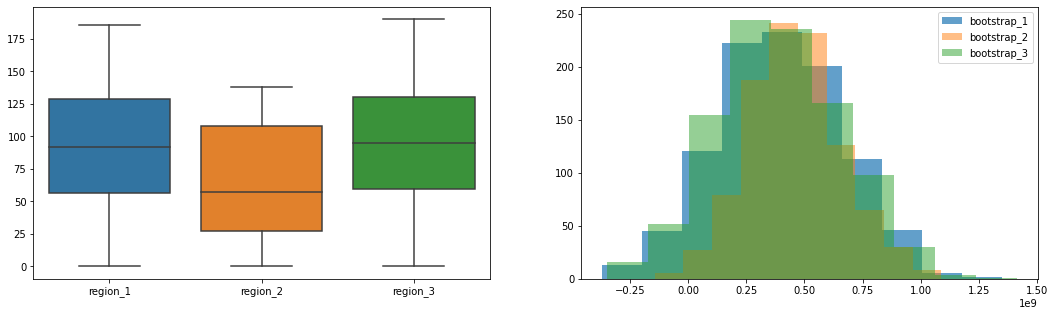

In [42]:
bootstrap = pd.concat([bootstrap_1, bootstrap_2, bootstrap_3], axis= 1)
bootstrap.columns = ['bootstrap_1', 'bootstrap_2', 'bootstrap_3']

fig, axis = plt.subplots(1,2 , figsize=(18,5))

sns.boxplot(data=product, ax=axis[0])
plt.hist(bootstrap_1, alpha = 0.7, label='bootstrap_1')
plt.hist(bootstrap_2, alpha = 0.5, label='bootstrap_2')
plt.hist(bootstrap_3, alpha = 0.5, label='bootstrap_3')
plt.legend(loc='upper right')
plt.show()

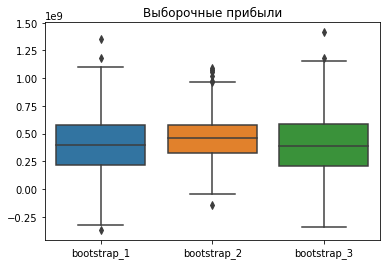

In [48]:
# КОД РЕВЬЮЕРА
sns.boxplot(data=bootstrap)
plt.title("Выборочные прибыли")
plt.show()

**ВЫВОД** 

***Cамый перспективный регион для новых разработок - второй т.к. имеет минимальный риск убытков в 0.7%, что удовлетворяет условию задания.***.